# Basis processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('testx.csv', index_col=0)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (13,21,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train.head()

,y,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
1,0,36000,36000,36000.0,60 months,17.97,913.58,D,D1,Pharmacist,...,4.0,100.0,22.2,0.0,0.0,259812.0,138100.0,76800.0,181515.0,Cash
2,0,3000,3000,3000.0,36 months,17.97,108.42,D,D1,IT Assistant,...,1.0,100.0,30.0,1.0,0.0,69552.0,31910.0,20000.0,37734.0,Cash
3,0,35000,35000,35000.0,36 months,12.98,1178.96,B,B5,Anti Money Laundering Compliance Manager,...,1.0,100.0,100.0,0.0,0.0,76400.0,63497.0,56800.0,11000.0,DirectPay
4,0,26500,26500,26500.0,60 months,11.31,580.28,B,B3,Compliance Director,...,4.0,100.0,66.7,0.0,0.0,430403.0,107975.0,49300.0,88875.0,DirectPay
5,0,3000,3000,3000.0,36 months,15.02,104.03,C,C3,Banker,...,3.0,95.0,25.0,0.0,0.0,400137.0,60074.0,11500.0,50524.0,Cash


向下转换格式，节省内存：

In [4]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


train = downcast_dtypes(train)
test = downcast_dtypes(test)

第13(annual_inc)、21(delinq_2yrs)、29(total_acc)个变量有混合类型，对它们进行处理：

In [5]:
train['annual_inc']

1          160000
2           50000
3          112000
4          134000
5           60000
6           42300
7           96000
8           56000
9           45000
10          30000
11          50000
12          47000
13           5000
14          50000
15          60000
16          70200
17         140000
18          95000
19          30000
20         145000
21          35000
22         100000
23         240000
24          32000
25          40000
26         110000
27          96500
28          30000
29          75000
30          29000
            ...  
1130271     65000
1130272     38220
1130273     50000
1130274     60000
1130275     46535
1130276     70000
1130277     50000
1130278     43000
1130279     55000
1130280     37000
1130281     75856
1130282     38950
1130283     92000
1130284     80000
1130285     94000
1130286     55000
1130287     72000
1130288    103510
1130289     70000
1130290     31000
1130291     33000
1130292     40000
1130293     48000
1130294     20736
1130295   

### annual_inc

In [6]:
train['annual_inc'].astype(np.float)

ValueError: could not convert string to float: 'Not Verified'

存在 'Not Verified' 变量，设为缺失值：

In [7]:
train.loc[train['annual_inc'] == 'Not Verified', 'annual_inc'] = np.nan
train['annual_inc'] = train['annual_inc'].astype(np.float)

### delinq_2yrs

In [6]:
train['delinq_2yrs'].value_counts()

0           905890
1           138982
2            39871
3            14552
0            13675
4             6586
5             3312
6             1921
1             1856
7              993
8              581
2              514
9              370
10             276
3              167
11             165
12             128
13              88
4               77
14              68
15              42
5               31
16              24
18              17
19              12
7               12
6               12
20              11
17              10
8                9
9                8
21               5
23               2
26               2
10               2
Jan-1996         1
13               1
21               1
12               1
Jan-1997         1
11               1
58               1
22               1
36               1
35               1
32               1
30               1
27               1
24               1
Name: delinq_2yrs, dtype: int64

存在 'Jan-1996', 'Jan-1997'的异常值，设为众数0：

In [8]:
train.loc[train['delinq_2yrs'].isin(
    ['Jan-1996', 'Jan-1997']), 'delinq_2yrs'] = 0
train['delinq_2yrs'] = train['delinq_2yrs'].astype(np.float)

### total_acc

In [8]:
train['total_acc'].value_counts()

20     40841
19     40537
18     40459
17     40102
21     39983
16     39203
22     39113
23     38341
15     37963
24     37196
14     36661
25     35730
13     34612
26     34108
27     32188
12     32141
28     30208
11     29405
29     29011
30     27240
10     26277
31     25241
32     23673
9      22675
33     21848
34     20207
8      18960
35     18476
36     17115
37     15828
       ...  
140        2
80         1
125        1
124        1
122        1
f          1
122        1
128        1
71         1
121        1
w          1
72         1
70         1
130        1
87         1
136        1
137        1
78         1
85         1
141        1
144        1
145        1
146        1
151        1
153        1
157        1
165        1
176        1
84         1
148        1
Name: total_acc, Length: 228, dtype: int64

存在 'f', 'w'的异常值，设为NaN：

In [9]:
train.loc[train['total_acc'].isin(['f', 'w']), 'total_acc'] = np.nan
train['total_acc'] = train['total_acc'].astype(np.float)

In [10]:
train['total_acc'].value_counts()

20.0     41442
19.0     41118
18.0     41032
17.0     40719
21.0     40551
16.0     39817
22.0     39709
23.0     38862
15.0     38591
24.0     37691
14.0     37268
25.0     36207
13.0     35191
26.0     34516
12.0     32679
27.0     32578
28.0     30618
11.0     29892
29.0     29387
30.0     27562
10.0     26730
31.0     25564
32.0     24015
9.0      23099
33.0     22112
34.0     20453
8.0      19337
35.0     18704
36.0     17333
37.0     16014
         ...  
118.0        5
116.0        4
117.0        3
133.0        3
120.0        3
108.0        3
115.0        2
119.0        2
122.0        2
123.0        2
114.0        2
112.0        2
140.0        2
146.0        1
165.0        1
144.0        1
157.0        1
153.0        1
151.0        1
176.0        1
148.0        1
124.0        1
145.0        1
141.0        1
137.0        1
136.0        1
130.0        1
125.0        1
121.0        1
128.0        1
Name: total_acc, Length: 141, dtype: int64

## 变量类型分类：

In [5]:
cat_feats = list(train.drop(
    'y', axis=1).select_dtypes(include=['object']).columns)
num_feats = list(train.drop(
    'y', axis=1).select_dtypes(exclude=['object']).columns)

In [6]:
cat_feats

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'delinq_2yrs',
 'earliest_cr_line',
 'total_acc',
 'initial_list_status',
 'application_type',
 'disbursement_method']

In [12]:
cat_feats

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'disbursement_method']

In [13]:
num_feats

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'annual_inc_joint',
 'dti_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'nu

# 处理分类型变量

In [11]:
cat_feats

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'disbursement_method']

## 异常值处理

查看每个分类变量不同取值的数量：

In [14]:
train['term'].value_counts()

 36 months    804746
 60 months    325554
Name: term, dtype: int64

In [12]:
train[cat_feats].nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              300122
emp_length                 12
home_ownership              7
verification_status         4
pymnt_plan                  2
purpose                    16
title                   34830
zip_code                  934
addr_state                 53
earliest_cr_line          726
initial_list_status         4
application_type            2
disbursement_method         3
dtype: int64

对分类变量分别用value_counts()进行检验，探查是否有异常值：

In [13]:
for feat in cat_feats:
    print(train[feat].value_counts())

 36 months    804746
 60 months    325554
Name: term, dtype: int64
B    331395
C    325202
A    216566
D    162317
E     67846
F     20901
G      6073
Name: grade, dtype: int64
C1    72981
B5    70163
B4    70008
B3    65411
C2    65308
C3    64690
C4    63875
B2    63324
B1    62489
C5    58348
A5    53695
A4    48100
A1    43579
D1    41297
A3    36466
D2    36283
A2    34726
D3    32418
D4    28475
D5    23844
E1    16745
E2    14953
E3    13432
E5    11389
E4    11327
F1     6655
F2     4659
F3     3893
F4     3121
F5     2573
G1     2075
G2     1333
G3     1020
G4      854
G5      791
Name: sub_grade, dtype: int64
Teacher                                 19308
Manager                                 17103
Owner                                   10935
Registered Nurse                         7748
Driver                                   7471
RN                                       7413
Supervisor                               7141
Sales                                    6539
Proje

Name: zip_code, Length: 934, dtype: int64
CA       157557
TX        93210
NY        93049
FL        80871
IL        45504
NJ        41882
PA        38266
OH        37670
GA        37069
NC        31503
VA        31292
MI        29286
MD        26873
AZ        26856
MA        25823
CO        24067
WA        23579
MN        19751
IN        18649
TN        17974
MO        17968
CT        17929
NV        16539
WI        15079
SC        14057
AL        13634
OR        13233
LA        12779
KY        10943
OK        10385
KS         9496
AR         8487
UT         7396
MS         6299
NM         6055
NH         5539
HI         5349
RI         4990
WV         4214
NE         3947
DE         3215
MT         3080
DC         2687
AK         2657
VT         2471
ME         2449
WY         2367
SD         2323
ID         2174
ND         1817
IA            9
20.68         1
16.33         1
Name: addr_state, dtype: int64
Sep-2004    7745
Sep-2003    7639
Sep-2005    7354
Aug-2003    7341
Aug-2001   

In [14]:
for feat in cat_feats:
    print(test[feat].value_counts())

 36 months    21342
 60 months     8658
Name: term, dtype: int64
B    8836
C    8832
A    5797
D    4169
E    1683
F     527
G     156
Name: grade, dtype: int64
C1    2009
B4    1863
B5    1832
B1    1757
C2    1746
B2    1733
C3    1733
C4    1712
B3    1651
C5    1632
A5    1459
A1    1219
A4    1197
D1    1081
A3     961
A2     961
D2     934
D3     796
D4     762
D5     596
E1     400
E2     368
E3     324
E4     312
E5     279
F1     166
F2     111
F3     107
F4      75
F5      68
G1      54
G2      32
G3      27
G5      24
G4      19
Name: sub_grade, dtype: int64
Teacher                            519
Manager                            433
Owner                              327
RN                                 239
Registered Nurse                   221
Sales                              196
Driver                             195
Supervisor                         180
Project Manager                    156
Director                           148
President                         

Name: addr_state, dtype: int64
Sep-05    217
Sep-03    210
Aug-01    206
Aug-04    204
Aug-06    202
Oct-03    202
Aug-05    198
Oct-04    194
Sep-04    191
Sep-02    189
Jul-03    189
Jun-05    188
Aug-00    188
Aug-03    181
Oct-02    179
Jul-04    177
Aug-02    177
Nov-02    172
Oct-05    168
Mar-05    167
Mar-04    167
Nov-99    167
Mar-06    166
Apr-02    165
Nov-05    164
Apr-06    163
Jul-02    162
Oct-01    162
Nov-00    162
Jan-05    161
         ... 
Oct-63      1
Aug-67      1
Aug-63      1
Jan-71      1
Feb-73      1
Nov-70      1
Jun-74      1
Jan-67      1
Oct-64      1
May-66      1
Dec-71      1
Oct-68      1
Feb-67      1
Dec-56      1
Feb-71      1
May-68      1
Jul-66      1
Dec-68      1
Jan-56      1
Jun-70      1
Aug-66      1
Jul-68      1
Jun-63      1
Aug-65      1
Feb-70      1
Jan-64      1
Nov-69      1
Jan-62      1
Aug-60      1
Feb-74      1
Name: earliest_cr_line, Length: 602, dtype: int64
w    21808
f     8192
Name: initial_list_status, dtype: int64
Ind

对取值太多的 'emp_title', 'title', 'zip_code'变量，我们直接将其舍去；而对'earliest_cr_line'，虽然其也有七百多个取值，但似乎可以进一步处理，因此暂时保留：

In [15]:
train.drop(['emp_title', 'title', 'zip_code'], axis=1, inplace=True)
test.drop(['emp_title', 'title', 'zip_code'], axis=1, inplace=True)

接下来依次对探查出的异常值进行处理，设为众数或者缺失值：

In [16]:
train.loc[train['emp_length'] == 'MORTGAGE', 'emp_length'] = np.nan
train.loc[train['home_ownership']=='35000', 'home_ownership'] = 'MORTGAGE'
train.loc[train['verification_status']=='Jun-2017', 'verification_status'] = 'Verified'
train.loc[train['purpose'] == "Credit card refinancing",
          'purpose'] = 'credit_card'
train.loc[train['purpose'] == "Paying off my son's dept...",
          'purpose'] = 'educational'
train.loc[train['addr_state'].isin(['20.68', '16.33']), 'addr_state'] = 'CA'
train.loc[~train['initial_list_status'].isin(['w', 'f']), 'initial_list_status'] = 'w'
train.loc[train['disbursement_method']=='N', 'disbursement_method'] = 'Cash'

将删除的变量从list中剔除：

In [17]:
cat_feats

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'disbursement_method']

In [18]:
cat_feats.pop(cat_feats.index('emp_title'))
cat_feats.pop(cat_feats.index('title'))
cat_feats.pop(cat_feats.index('zip_code'))

'zip_code'

In [19]:
cat_feats

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'disbursement_method']

## 缺失值处理

In [18]:
train[cat_feats].isnull().sum()

term                       0
grade                      0
sub_grade                  0
emp_length             73449
home_ownership             0
verification_status        0
pymnt_plan                 1
purpose                    0
addr_state                 0
earliest_cr_line          15
initial_list_status        0
application_type           2
disbursement_method        0
dtype: int64

In [19]:
test[cat_feats].isnull().sum()

term                      0
grade                     0
sub_grade                 0
emp_length             2075
home_ownership            0
verification_status       0
pymnt_plan                0
purpose                   0
addr_state                0
earliest_cr_line          0
initial_list_status       0
application_type          0
disbursement_method       0
dtype: int64

用众数填补缺失值：

In [22]:
train.loc[train['emp_length'].isnull(), 'emp_length'] = '10+ years'
test.loc[test['emp_length'].isnull(), 'emp_length'] = '10+ years'
train.loc[train['pymnt_plan'].isnull(), 'pymnt_plan'] = 'n'
train.loc[train['application_type'].isnull(), 'application_type'] = 'Individual'

In [21]:
# train.loc[train['num_tl_120dpd_2m'].isnull(), 'num_tl_120dpd_2m'] = 0
# train.loc[train['num_tl_30dpd'].isnull(), 'num_tl_30dpd'] = 0
# test.loc[test['num_tl_120dpd_2m'].isnull(), 'num_tl_120dpd_2m'] = 0

## 分离出有序变量

将有序的分类型变量单独提出来，使用不同的方法对它们进行编码，以保留顺序的信息：

In [21]:
train.shape

(1130300, 86)

In [22]:
train['emp_length'].value_counts()

10+ years    447320
2 years      101871
< 1 year      94750
3 years       90235
1 year        74337
5 years       70121
4 years       67898
6 years       51547
7 years       46278
8 years       46010
9 years       39933
Name: emp_length, dtype: int64

In [23]:
ord_feats = ['grade', 'emp_length']
cat_feats = list(set(cat_feats)-set(ord_feats))

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130300 entries, 1 to 1130300
Data columns (total 86 columns):
y                             1130300 non-null int32
loan_amnt                     1130300 non-null int32
funded_amnt                   1130300 non-null int32
funded_amnt_inv               1130300 non-null float32
term                          1130300 non-null object
int_rate                      1130300 non-null float32
installment                   1130300 non-null float32
grade                         1130300 non-null object
sub_grade                     1130300 non-null object
emp_length                    1130300 non-null object
home_ownership                1130300 non-null object
annual_inc                    1130297 non-null float64
verification_status           1130300 non-null object
pymnt_plan                    1130300 non-null object
purpose                       1130300 non-null object
addr_state                    1130300 non-null object
dti                   

In [25]:
# cat_feats = list(train.drop(
#     'y', axis=1).select_dtypes(include=['object']).columns)
# num_feats = list(train.drop(
#     'y', axis=1).select_dtypes(exclude=['object']).columns)

## 处理 earliest_cr_line

In [26]:
train['earliest_cr_line'].value_counts()

Sep-2004    7745
Sep-2003    7639
Sep-2005    7354
Aug-2003    7341
Aug-2001    7135
Aug-2002    7135
Aug-2005    7103
Aug-2004    7015
Oct-2003    6981
Aug-2006    6972
Oct-2004    6877
Sep-2002    6816
Oct-2002    6804
Aug-2000    6716
Oct-2001    6640
Jul-2003    6623
Oct-2000    6469
Nov-2004    6247
Jul-2004    6205
Nov-1999    6127
Sep-2001    6090
Sep-2000    6051
Oct-2005    6032
Nov-2000    6016
Nov-2001    5960
Mar-2004    5955
Jun-2005    5929
Sep-2006    5908
Oct-1999    5898
Nov-2003    5814
            ... 
Jan-1954       2
May-1955       1
May-1957       1
Dec-1946       1
Feb-1958       1
Jan-1946       1
0              1
Dec-1951       1
Jan-1948       1
1              1
Jul-1955       1
Aug-1955       1
Feb-1960       1
Apr-1934       1
Sep-1951       1
Nov-1953       1
Feb-1959       1
Dec-1950       1
Mar-1954       1
Aug-1941       1
Apr-1957       1
Aug-1950       1
Jan-1944       1
Jun-1956       1
Nov-1955       1
Nov-1952       1
May-1958       1
Nov-1956      

我们可以计算这个日期到现在的年数，并用中位数填补缺失值：

In [25]:
def process_ecl(x):
    if (type(x)==str):
        if '-' in x:
            return 2016 - int(x.split('-')[1])
    return np.nan

In [26]:
train['earliest_cr_line']

1          Sep-2008
2          Apr-2007
3          Aug-2004
4          Dec-2006
5          Oct-2006
6          Jul-2014
7          May-2005
8          Dec-2004
9          Oct-2006
10         Jun-1995
11         Aug-2007
12         Jul-1996
13         Aug-1998
14         Dec-2007
15         Aug-2008
16         Dec-2005
17         Dec-1997
18         Mar-2009
19         Jul-2005
20         May-1975
21         Apr-2014
22         Oct-1996
23         Mar-1999
24         Jan-2008
25         Apr-2014
26         Oct-2000
27         May-2009
28         Aug-1993
29         Dec-1997
30         Apr-2000
             ...   
1130271    Sep-1988
1130272    Mar-2011
1130273    Sep-1997
1130274    Nov-2001
1130275    Dec-2011
1130276    Apr-2009
1130277    Mar-2013
1130278    Jun-2004
1130279    Oct-2006
1130280    Feb-2003
1130281    Aug-1998
1130282    Nov-2013
1130283    Dec-1994
1130284    Nov-1993
1130285    Nov-1997
1130286    Nov-2003
1130287    Mar-1997
1130288    Mar-1992
1130289    Dec-2005


In [27]:
train['cr_line_year'] = train['earliest_cr_line'].apply(process_ecl)
train.loc[train['cr_line_year'].isnull(), 'cr_line_year'] = train['cr_line_year'].median()

test['cr_line_year'] = test['earliest_cr_line'].apply(process_ecl)
test.loc[test['cr_line_year'].isnull(), 'cr_line_year'] = test['cr_line_year'].median()

从分类型变量中去除 'eaeliest_cr_line', 把 'cr_line_year' 加入数值变量：

In [28]:
cat_feats.pop(cat_feats.index('earliest_cr_line'))

'earliest_cr_line'

In [29]:
num_feats.append('cr_line_year')
train.drop('earliest_cr_line', axis=1, inplace=True)
test.drop('earliest_cr_line', axis=1, inplace=True)

# 处理数值型变量

查看每个数值型变量不同取值的数量：

In [30]:
num_nunique = train[num_feats].nunique()
num_nunique

loan_amnt                       1568
funded_amnt                     1568
funded_amnt_inv                 5734
int_rate                         665
installment                    79016
annual_inc                     56977
dti                             8896
delinq_2yrs                       32
inq_last_6mths                    25
mths_since_last_record           127
open_acc                          82
pub_rec                           37
revol_bal                      81895
revol_util                      1299
total_acc                        141
out_prncp                     217784
out_prncp_inv                 225118
total_pymnt                   798876
total_pymnt_inv               774321
total_rec_prncp               300916
annual_inc_joint               10032
dti_joint                       3929
tot_coll_amt                   11797
tot_cur_bal                   379237
open_acc_6m                       18
open_act_il                       49
open_il_12m                       18
o

## 异常值探查

对每个数值型变量，我们都画出箱线图：

In [32]:
len(num_feats)

73

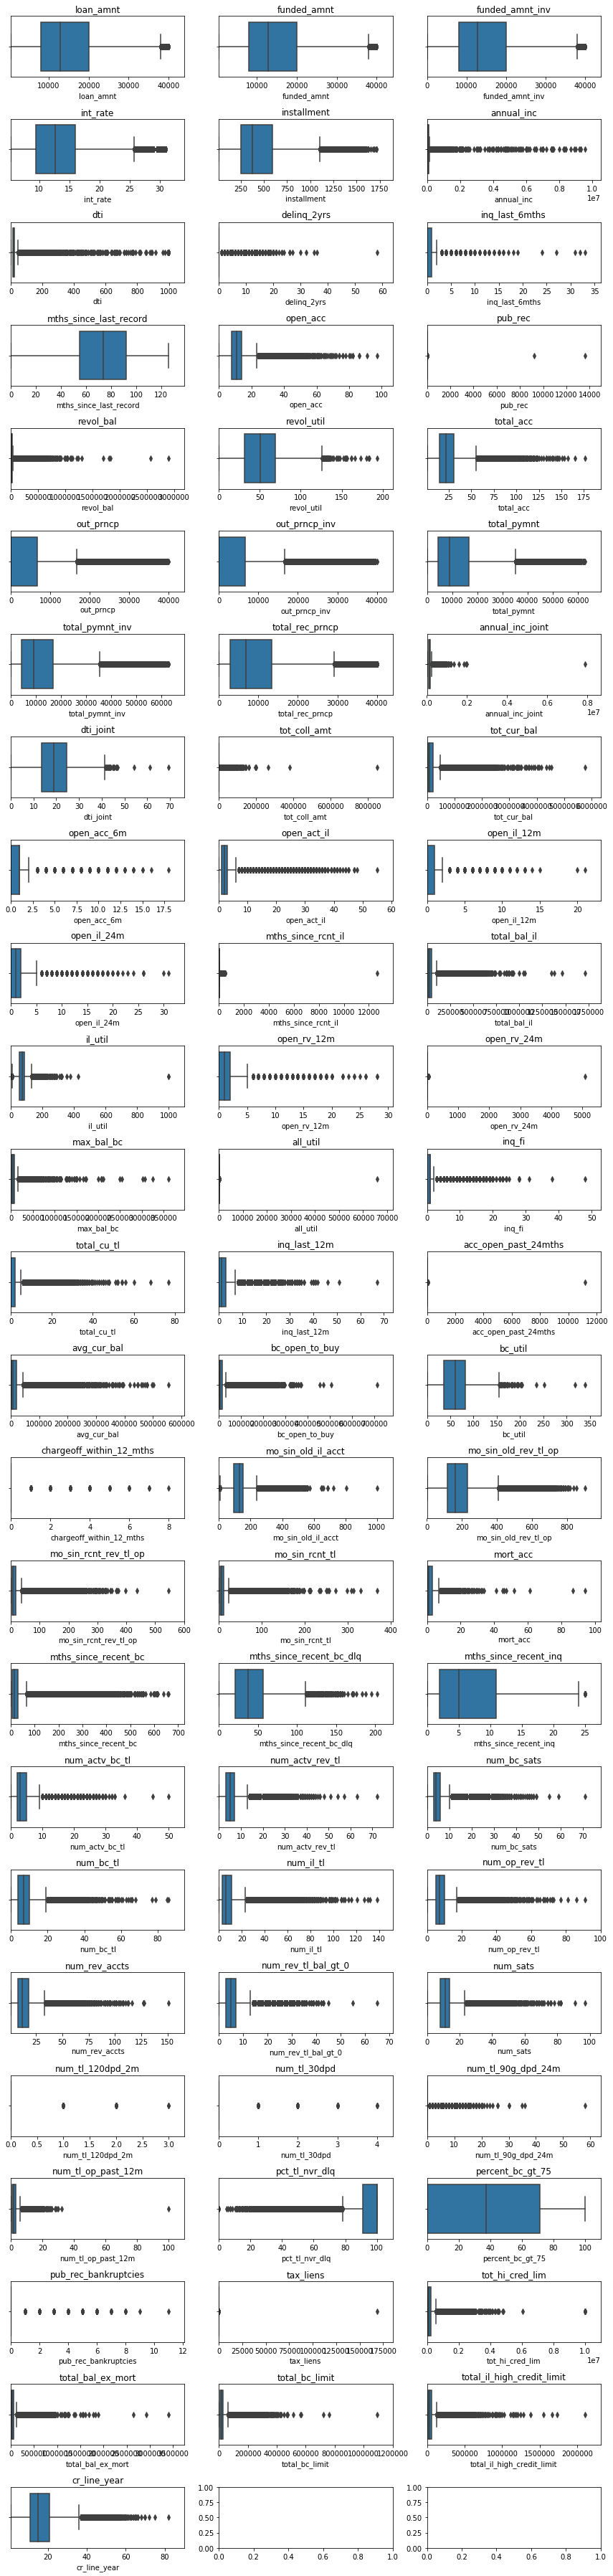

In [31]:
fig, axes = plt.subplots(nrows=25, ncols=3, figsize=(3*4, 25*2))
for i, feat in tqdm_notebook(enumerate(num_feats)):
    sns.boxplot(x=train[feat], ax=axes.flatten()[i])
    ax=axes.flatten()[i]
    ax.set_xlim(train[feat].min(), train[feat].max()*1.1)
    ax.set_title(feat)
plt.tight_layout()

将超过均值15倍标准差的样本进行剪切：

In [33]:
for feat in num_feats:
    border = train[feat].mean()+15*train[feat].std()
    train.loc[train[feat]>border, feat] = border
    border = test[feat].mean()+15*test[feat].std()
    test.loc[test[feat]>border, feat] = border

## 缺失值探查

计算每个数值变量缺失值所占的比例：

In [34]:
total_num = train[num_feats].isnull().sum().sort_values(ascending=False)

perc = train[num_feats].isnull().sum()/train[num_feats].isnull().count() * 100
perc1 = (round(perc, 2).sort_values(ascending=False))

num_miss = pd.concat([total_num, perc1], axis=1, keys=[
                       "Total Missing Values", "Percentage %"]).sort_values(by="Percentage %", ascending=False)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  import sys


In [35]:
num_miss

,Total Missing Values,Percentage %
annual_inc_joint,1070065,94.67
dti_joint,1070067,94.67
mths_since_last_record,950583,84.10
mths_since_recent_bc_dlq,870397,77.01
il_util,534474,47.29
mths_since_rcnt_il,455058,40.26
all_util,433322,38.34
open_act_il,433210,38.33
open_rv_12m,433210,38.33
open_il_12m,433210,38.33


大部分数值变量都有缺失值。我们将缺失值比例超过75%的变量剔除，其他变量用中位数来填补缺失值：

In [36]:
for feat in tqdm_notebook(num_feats):
    if num_miss.loc[feat, 'Percentage %']>75:
        train.drop(feat, axis=1, inplace=True)
        test.drop(feat, axis=1, inplace=True)
    else:
        train.loc[train[feat].isnull(), feat] = train[feat].median()
        test.loc[test[feat].isnull(), feat] = test[feat].median()

In [37]:
num_feats = list(train.drop(
    'y', axis=1).select_dtypes(exclude=['object']).columns)

# 特征工程

In [38]:
print('Categorical Features:')
print(cat_feats)
print('Ordinal Features:')
print(ord_feats)
print('Numerical Features:')
print(num_feats)

Categorical Features:
['addr_state', 'home_ownership', 'initial_list_status', 'disbursement_method', 'pymnt_plan', 'purpose', 'sub_grade', 'application_type', 'term', 'verification_status']
Ordinal Features:
['grade', 'emp_length']
Numerical Features:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_rec

In [39]:
def enc_data(encoder, train, test_list):
    train_array = encoder.fit_transform(train)
    test_array_list = []
    for i in test_list:
        test_array_list.append(encoder.transform(i))
    return train_array, test_array_list

划分训练集和验证集：

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train.drop(
    'y', axis=1), train['y'], test_size=0.1, random_state=42, stratify=train['y'])

In [42]:
from sklearn.preprocessing import StandardScaler
num_enc = StandardScaler()
train_num, [val_num, test_num] = enc_data(num_enc, X_train[num_feats].values,
                                                     [X_val[num_feats].values, test[num_feats].values])

In [44]:
train_num[:,0]

array([ 0.32163295, -1.20158455,  0.53923545, ...,  1.0832417 ,
        0.97444045,  2.28005544])

In [45]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
train_ord, [val_ord, test_ord] = enc_data(ord_enc, X_train[ord_feats].values, [X_val[ord_feats].values, test[ord_feats].values])

In [46]:
train_ord[:,0]

array([1., 1., 0., ..., 0., 0., 3.])

In [47]:
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder(sparse=False)
train_oh, [val_oh, test_oh] = enc_data(oh_enc, X_train[cat_feats].values, [X_val[cat_feats].values, test[cat_feats].values])

In [48]:
train_oh[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
train_oh.shape

(1017270, 119)

In [46]:
train_mat = np.c_[train_ord, train_oh, train_num]
val_mat = np.c_[val_ord, val_oh, val_num]
test_mat = np.c_[test_ord, test_oh, test_num]

In [47]:
train_mat

array([[ 1.        ,  5.        ,  1.        , ..., -0.31857417,
        -0.24181263, -0.32371597],
       [ 1.        , 10.        ,  1.        , ..., -0.89553519,
         0.28771325, -1.08762028],
       [ 0.        ,  1.        ,  0.        , ...,  0.06459841,
         1.19129875,  1.84067957],
       ...,
       [ 0.        ,  3.        ,  0.        , ..., -0.53438402,
         0.8604016 , -0.83298551],
       [ 0.        ,  5.        ,  1.        , ...,  2.46052812,
         0.01609949,  0.82214049],
       [ 3.        , 10.        ,  0.        , ..., -0.35380843,
        -0.23554966, -1.46957243]])

In [49]:
import gc
del train, test, train_num, train_oh, train_ord
gc.collect()

258

In [49]:
# from hyperopt import fmin, hp, tpe

# def objective(params):
#     lgb_clf = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], valid_names=[
#         'train', 'validation'], feval=lgb_f1_score,
#         num_boost_round=1000, early_stopping_rounds=50)
#     print(lgb_clf.params)
#     y_pred_proba = lgb_clf.predict(val_mat)
#     y_pred = np.round(y_pred_proba)
#     f1_ = f1_score(y_val, y_pred)
#     return -f1_


# space = {
#     'max_depth': hp.choice('max_depth', np.arange(5, 15, 1, dtype=int)),
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
#     'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(5, 30, 1, dtype=int)),
#     'learning_rate': hp.quniform('learning_rate', 0.05, 0.3, 0.05),
#     'seed': 42,
#     'objective': 'binary',
#     'verbose': 0
# }

In [50]:
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=20)
# print("The best hyperparameters are: ")
# print(best)

In [51]:
import lightgbm as lgb
params = {
    'max_depth': 13,
    'bagging_fraction': 0.9,
    'colsample_bytree': 0.6,
    'num_leaves': 112,
    'min_data_in_leaf': 27,
    'learning_rate': 0.05,
    'seed': 42,
    'objective': 'binary',
    'verbose': 0
}

In [55]:
import time

lgb_train = lgb.Dataset(train_mat, y_train)
lgb_eval = lgb.Dataset(val_mat, y_val)

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

start = time.time()
lgb_clf_new = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], valid_names=[
    'train', 'validation'], feval=lgb_f1_score,
    num_boost_round=2000, early_stopping_rounds=100)
print(time.time()-start)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[1]	train's binary_logloss: 0.352998	train's f1: 0	validation's binary_logloss: 0.353056	validation's f1: 0
Training until validation scores don't improve for 100 rounds.


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[2]	train's binary_logloss: 0.335123	train's f1: 0	validation's binary_logloss: 0.335002	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[3]	train's binary_logloss: 0.31193	train's f1: 0	validation's binary_logloss: 0.311817	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[4]	train's binary_logloss: 0.302523	train's f1: 0	validation's binary_logloss: 0.302411	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[5]	train's binary_logloss: 0.294512	train's f1: 0	validation's binary_logloss: 0.294434	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[6]	train's binary_logloss: 0.274701	train's f1: 0	validation's binary_logloss: 0.27456	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[7]	train's binary_logloss: 0.265376	train's f1: 0	validation's binary_logloss: 0.265159	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[8]	train's binary_logloss: 0.261933	train's f1: 0	validation's binary_logloss: 0.261788	validation's f1: 0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[9]	train's binary_logloss: 0.253862	train's f1: 0	validation's binary_logloss: 0.253639	validation's f1: 0
[10]	train's binary_logloss: 0.240128	train's f1: 0.00384216	validation's binary_logloss: 0.239862	validation's f1: 0.00373857
[11]	train's binary_logloss: 0.229325	train's f1: 0.340914	validation's binary_logloss: 0.229074	validation's f1: 0.334893
[12]	train's binary_logloss: 0.21774	train's f1: 0.523368	validation's binary_logloss: 0.217462	validation's f1: 0.525542
[13]	train's binary_logloss: 0.213608	train's f1: 0.551399	validation's binary_logloss: 0.213362	validation's f1: 0.55126
[14]	train's binary_logloss: 0.203638	train's f1: 0.598258	validation's binary_logloss: 0.203345	validation's f1: 0.600982
[15]	train's binary_logloss: 0.194536	train's f1: 0.65142	validation's binary_logloss: 0.19423	validation's f1: 0.655275
[16]	train's binary_logloss: 0.187637	train's f1: 0.714382	validation's binary_logloss: 0.187343	validation's f1: 0.712533
[17]	train's binary_logloss: 0.

[140]	train's binary_logloss: 0.0612053	train's f1: 0.93688	validation's binary_logloss: 0.0647615	validation's f1: 0.937567
[141]	train's binary_logloss: 0.0610951	train's f1: 0.936922	validation's binary_logloss: 0.064681	validation's f1: 0.937571
[142]	train's binary_logloss: 0.061012	train's f1: 0.936952	validation's binary_logloss: 0.064631	validation's f1: 0.937604
[143]	train's binary_logloss: 0.0609352	train's f1: 0.93696	validation's binary_logloss: 0.0646275	validation's f1: 0.937567
[144]	train's binary_logloss: 0.06086	train's f1: 0.936985	validation's binary_logloss: 0.064595	validation's f1: 0.937567
[145]	train's binary_logloss: 0.0607914	train's f1: 0.936982	validation's binary_logloss: 0.0645862	validation's f1: 0.937567
[146]	train's binary_logloss: 0.0607251	train's f1: 0.937007	validation's binary_logloss: 0.0645737	validation's f1: 0.937604
[147]	train's binary_logloss: 0.0606617	train's f1: 0.937015	validation's binary_logloss: 0.0645598	validation's f1: 0.937604


[270]	train's binary_logloss: 0.052806	train's f1: 0.938068	validation's binary_logloss: 0.0632448	validation's f1: 0.938145
[271]	train's binary_logloss: 0.0527575	train's f1: 0.93808	validation's binary_logloss: 0.0632441	validation's f1: 0.938145
[272]	train's binary_logloss: 0.052707	train's f1: 0.938093	validation's binary_logloss: 0.0632377	validation's f1: 0.938145
[273]	train's binary_logloss: 0.05265	train's f1: 0.938097	validation's binary_logloss: 0.0632434	validation's f1: 0.938145
[274]	train's binary_logloss: 0.0526029	train's f1: 0.938113	validation's binary_logloss: 0.0632359	validation's f1: 0.938145
[275]	train's binary_logloss: 0.0525585	train's f1: 0.938114	validation's binary_logloss: 0.0632331	validation's f1: 0.938145
[276]	train's binary_logloss: 0.0525027	train's f1: 0.938122	validation's binary_logloss: 0.0632284	validation's f1: 0.938145
[277]	train's binary_logloss: 0.0524442	train's f1: 0.938126	validation's binary_logloss: 0.0632183	validation's f1: 0.9381

[400]	train's binary_logloss: 0.0470551	train's f1: 0.939101	validation's binary_logloss: 0.0628644	validation's f1: 0.938296
[401]	train's binary_logloss: 0.0470118	train's f1: 0.939105	validation's binary_logloss: 0.0628665	validation's f1: 0.938296
[402]	train's binary_logloss: 0.0469685	train's f1: 0.939109	validation's binary_logloss: 0.0628718	validation's f1: 0.938296
[403]	train's binary_logloss: 0.0469259	train's f1: 0.93913	validation's binary_logloss: 0.0628756	validation's f1: 0.938296
[404]	train's binary_logloss: 0.0468762	train's f1: 0.939151	validation's binary_logloss: 0.0628762	validation's f1: 0.938296
[405]	train's binary_logloss: 0.0468462	train's f1: 0.93916	validation's binary_logloss: 0.0628749	validation's f1: 0.938296
[406]	train's binary_logloss: 0.0467962	train's f1: 0.939164	validation's binary_logloss: 0.0628756	validation's f1: 0.938296
[407]	train's binary_logloss: 0.0467572	train's f1: 0.939197	validation's binary_logloss: 0.0628777	validation's f1: 0.9

[530]	train's binary_logloss: 0.0422664	train's f1: 0.940776	validation's binary_logloss: 0.062668	validation's f1: 0.938518
[531]	train's binary_logloss: 0.0422386	train's f1: 0.940805	validation's binary_logloss: 0.0626707	validation's f1: 0.938518
[532]	train's binary_logloss: 0.0422144	train's f1: 0.940818	validation's binary_logloss: 0.062676	validation's f1: 0.938518
[533]	train's binary_logloss: 0.0421843	train's f1: 0.940818	validation's binary_logloss: 0.0626809	validation's f1: 0.938518
[534]	train's binary_logloss: 0.0421386	train's f1: 0.940834	validation's binary_logloss: 0.0626809	validation's f1: 0.938518
[535]	train's binary_logloss: 0.0421151	train's f1: 0.940843	validation's binary_logloss: 0.0626824	validation's f1: 0.938518
[536]	train's binary_logloss: 0.0420899	train's f1: 0.940876	validation's binary_logloss: 0.0626829	validation's f1: 0.938518
[537]	train's binary_logloss: 0.042047	train's f1: 0.940905	validation's binary_logloss: 0.0626737	validation's f1: 0.93

In [57]:
from sklearn.externals import joblib
joblib.dump(lgb_clf_new, 'lgb_clf_new.pkl')

['lgb_clf_new.pkl']

In [ ]:
# lgb_clf_new = joblib.load('lgb_clf_new.pkl')

In [56]:
y_val_pred = np.round(lgb_clf_new.predict(val_mat))
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
print('F-measure:')
print(f1_score(y_val, y_val_pred))
print('Kappa:')
print(cohen_kappa_score(y_val, y_val_pred))

F-measure:
0.9385554136511991
Kappa:
0.9298392348137685


In [ ]:
y_test_pred = np.round(lgb_clf_new.predict(test_mat))
pred_df = pd.DataFrame({'ID': range(1,30001), 'prediction': y_test_pred})
pred_df.to_csv('result_1.csv', index=False)

In [ ]:
pd.Series(y_test_pred).value_counts()